## Q learning with different exploration strategies

Authors: [johnjim0816](https://github.com/johnjim0816)  
Contributer: [Scc_hy](https://github.com/scchy)


## 加载需要的package

In [1]:
import numpy as np
import math
from collections import defaultdict
from enum import Enum
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gym
from gym import register
import os
import sys
import warnings
from tqdm import tqdm
from rich.console import Console
file_dir_name = os.path.dirname(os.getcwd())
os.environ['KMP_DUPLICATE_LIB_OK']='True'
if file_dir_name not in sys.path:
    sys.path.append(file_dir_name)

from gym.envs.toy_text import FrozenLakeEnv
from envs.simple_grid import DrunkenWalkEnv

# 可以将print输出美化
cs = Console()
warnings.filterwarnings('ignore')
cs.print(f"gym version == {gym.__version__}")

gym version == 0.25.2

## &#x1F680; 1、定义算法

In [2]:
class QLearning(object):
    def __init__(self,cfg):
        self.explore_type = cfg.explore_type # 探索策略类型
        self.n_actions = cfg.n_actions 
        self.lr = cfg.lr  # 学习率
        self.gamma = cfg.gamma  
        self.epsilon = cfg.epsilon_start
        self.sample_count = 0  
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.epsilon_decay_flag = cfg.epsilon_decay_flag
        self.Q_table  = np.zeros((cfg.n_states, self.n_actions)) # 用np.array 作为QTable 第一维为state， 第二维维每个state可以采取的action
        self.__ucb_init()
    
    @staticmethod
    def explore_type_space():
        return { 'epsilon_greedy', 'boltzmann', 'ucb', 'special_ucb', 'softmax', 'thompson'}
    
    def __softmax(self, actions_v):
        return np.exp(actions_v + 1e-3 ) / np.sum(np.exp(actions_v + 1e-3), axis=0)

    def __softmax_policy_init(self):
        self.Q_table = np.random.random(self.Q_table.shape)

    def __ucb_init(self):
        self.ucb_sa_visit_cnt_arr = np.array([])
        self.ucb_cnt = 0
        self.ucb_print = 0
        self.ucb_sa_visit_cnt_arr = np.ones(self.Q_table.shape)

    def _sp_ucb_policy(self, s):
        """ucb策略
        reference: 
        """
        self.ucb_cnt += 1
        # 先验action
        not_state_once = np.sum(self.ucb_sa_visit_cnt_arr > 1, axis=1).sum() < self.ucb_sa_visit_cnt_arr.shape[0]
        if not_state_once:
            a_final = self._e_greedy(s)
            self.ucb_sa_visit_cnt_arr[s, a_final] += 1
            return a_final

        self.ucb_print += 1
        if self.ucb_print == 1:
            print(f'UCB-Start {self.ucb_cnt}')
        b_t = self.__softmax(self.Q_table[s]) + self.__softmax(np.sqrt(2 * np.log(self.ucb_cnt) / self.ucb_sa_visit_cnt_arr[s]))
        a_final = np.argmax(b_t)
        self.ucb_sa_visit_cnt_arr[s, a_final] += 1
        return a_final
    
    def _e_greedy(self, state):
        self.epsilon = self.epsilon_end
        if self.epsilon_decay_flag:
            self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                math.exp(-1. * self.sample_count / self.epsilon_decay) # epsilon是会递减的，这里选择指数递减
        # e-greedy 策略
        if np.random.uniform(0, 1) < self.epsilon: # 随机选择动作
            return np.random.randint(len(self.Q_table[state]))
        if sum(self.Q_table[state]) != 0:
            return np.argmax(self.Q_table[state]) # 选择Q(s,a)最大对应的动作
        return np.random.randint(len(self.Q_table[state]))
        
    def sample_action(self, state):
        ''' 采样动作，训练时用
        '''
        self.sample_count += 1
        if self.explore_type == 'epsilon_greedy':
            return self._e_greedy(state)
        elif self.explore_type == 'boltzmann':
            # boltzmann 策略
            action_probs = np.exp(self.Q_table[int(state)] / self.epsilon) / np.sum(np.exp(self.Q_table[int(state)] / self.epsilon))
            action = np.random.choice(self.n_actions, p=action_probs)
            return action
        elif self.explore_type == 'ucb':
            # ucb 策略
            if self.sample_count < self.n_actions:
                action = self.sample_count
            else:
                action = np.argmax(
                    self.__softmax(self.Q_table[int(state)]) + 
                    self.__softmax(self.epsilon * np.sqrt(np.log(self.sample_count) / self.sample_count))
                )
            return action
        elif self.explore_type == 'special_ucb':
            return self._sp_ucb_policy(state)
        elif self.explore_type == 'softmax':
            if self.sample_count <= 1:
                self.__softmax_policy_init()
            # softmax 策略
            action_probs = np.exp(self.Q_table[int(state)] / self.epsilon) / np.sum(np.exp(self.Q_table[int(state)] / self.epsilon))
            action = np.random.choice(self.n_actions, p=action_probs)
            return action
        elif self.explore_type == 'thompson':
            # thompson 策略
            success_p = self.__softmax(self.Q_table[state])
            failed_p = 1 - success_p
            samples = np.random.beta(success_p, failed_p)
            return np.argmax(samples)
        else:
            raise NotImplementedError

    def predict_action(self,state):
        ''' 预测或选择动作，测试时用
        '''
        if self.explore_type == 'epsilon_greedy':
            action = np.argmax(self.Q_table[int(state)])
            return action
        elif self.explore_type == 'boltzmann':
            action_probs = np.exp(self.Q_table[int(state)] / self.epsilon) / np.sum(np.exp(self.Q_table[int(state)] / self.epsilon))
            action = np.random.choice(self.n_actions, p=action_probs)
            return action
        elif self.explore_type in ['ucb', 'special_ucb']:
            action = np.argmax(self.Q_table[int(state)])
            return action
        elif self.explore_type == 'softmax':
            action_probs = np.exp(self.Q_table[int(state)] / self.epsilon) / np.sum(np.exp(self.Q_table[int(state)] / self.epsilon))
            action = np.random.choice(self.n_actions, p=action_probs)
            return action
        elif self.explore_type == 'thompson':
            success_p = self.__softmax(self.Q_table[state])
            failed_p = 1 - success_p
            samples = np.random.beta(success_p, failed_p)
            return np.argmax(samples)
        else:
            raise NotImplementedError

    def update(self, state, action, reward, next_state, terminated):
        Q_predict = self.Q_table[int(state)][action] 
        if terminated: # 终止状态
            Q_target = reward  
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[int(next_state)]) 
        self.Q_table[int(state)][action] += self.lr * (Q_target - Q_predict)

## 2、定义训练

In [3]:
def all_seed(env, seed = 1):
    ''' omnipotent seed for RL, attention the position of seed function, you'd better put it just following the env create function
    Args:
        env (_type_): 
        seed (int, optional): _description_. Defaults to 1.
    '''
    import torch
    import numpy as np
    import random
    # print(f"seed = {seed}")
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')


def train(cfg, env, agent):
    out_dict = {'algo': cfg.algo_name, 'explore_type': cfg.explore_type}
    best = 1 if cfg.env_name == 'FrozenLakeEasy-v0' else 10
    def conv_finished(rewards):
        if len(rewards) <= 11:
            return len(rewards), False
        if np.mean(rewards[-11:-1]) == best:
            return len(rewards), np.mean(rewards[-11:-1]) == np.mean(rewards[-10:])
        return len(rewards), False

    print(f'环境:{cfg.env_name}, 算法:{cfg.algo_name}, 设备:{cfg.device}')
    rewards = []  # 记录奖励
    fi_flag = False
    tq_bar = tqdm(range(cfg.train_eps))
    all_seed(env, seed = cfg.seed)
    for i_ep in tq_bar:
        tq_bar.set_description(f'Tarin[ {i_ep + 1}/{cfg.train_eps} ](Epsilon：{agent.epsilon:.3f})')
        ep_reward = 0  # 记录每个回合的奖励
        ep_step = 0
        # 重置环境,即开始新的回合
        state = env.reset()  
        while cfg.max_step > ep_step:
            ep_step += 1
            action = agent.sample_action(state)  # 根据算法采样一个动作
            next_state, reward, terminated, info = env.step(action)  # 与环境进行一次动作交互
            agent.update(state, action, reward, next_state, terminated)  # Q学习算法更新
            state = next_state  # 更新状态
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        last_10_mean = np.mean(rewards[-10:])

        if not fi_flag:
            step, fi_flag = conv_finished(rewards)
            out_dict['conv_eps'] = step

        tq_bar.set_postfix(reward=f'{last_10_mean:.3f}')
        tq_bar.update()

    out_dict['rewards'] = rewards
    return out_dict  #TODO:可以加收敛的回合数


def test(cfg, env, agent):
    out_dict = {'algo': cfg.algo_name, 'explore_type': cfg.explore_type}
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = []  # 记录所有回合的奖励
    steps = []
    tq_bar = tqdm(range(cfg.test_eps))
    for i_ep in tq_bar:
        tq_bar.set_description(f'Test[ {i_ep + 1}/{cfg.test_eps} ](Epsilon：{agent.epsilon:.3f})')
        ep_step = 0 # 记录每个episode的智能体行走的次数
        ep_reward = 0  # 记录每个episode的reward
        env.seed(cfg.seed)
        state = env.reset()  # 重置环境, 重新开一局（即开始新的一个回合）
        while cfg.max_step > ep_step:
            action = agent.predict_action(state)  # 根据算法选择一个动作
            next_state, reward, terminated, info = env.step(action)  # 与环境进行一个交互
            state = next_state  # 更新状态
            ep_reward += reward
            ep_step += 1
            if terminated:
                break
        rewards.append(ep_reward)
        steps.append(ep_step)
        last_10_mean = np.mean(rewards[-10:])
        
        tq_bar.set_postfix(reward=f'{last_10_mean:.3f}')
        tq_bar.update()

    out_dict['rewards'] = rewards
    out_dict['steps'] = steps
    out_dict['meanReward'] = np.mean(rewards)
    out_dict['meanSteps'] = np.mean(steps)
    return out_dict

## 	&#x1F4CA; 3、一些可视化的工具
<font color=darkred>这部分脚本大家可以直接Copy使用</font>

In [4]:

class Direct(Enum):
    Left_v = 0
    Down_v = 1
    Right_v = 2
    Up_v = 3
    Left = -1
    Down = -1
    Right = +1
    Up = +1
    Left_s = r'$\Leftarrow$'
    Down_s = r'$\Downarrow$'
    Right_s = r'$\Rightarrow$'
    Up_s = r'$\Uparrow$'


class QTablePlot:
    def __init__(self, Q_table, env):
        self.Q_table = Q_table
        self.env = env
        self.env_rows, self.env_cols = env.nrow, env.ncol
        self.table = np.zeros((env.nrow * 3, env.ncol * 3))
        self.direct = Direct
        self.text_record_dict = {}
        self.record_SHG = {}

    def _fill_table(self, q_table: np.ndarray):
        text_str_list = [
            Direct.Left_s.value, 
            Direct.Down_s.value, 
            Direct.Right_s.value, 
            Direct.Up_s.value
        ]
        env_desc_str = ''.join(''.join(i) for i in self.env.desc.astype(str))
        for r in range(self.env_rows):
            for c in range(self.env_cols):
                s = r * self.env_cols + c
                center_r = 1 + (self.env_rows - r - 1) * 3
                # center_r = 1 + r * 3
                center_c = 1 + c * 3
                # "Left","Down","Right","Up"
                self.table[
                    center_r , center_c + Direct.Left.value
                ] = q_table[s, Direct.Left_v.value]
                self.table[
                    center_r , center_c + Direct.Right.value
                ] = q_table[s, Direct.Right_v.value]
                self.table[
                    center_r + Direct.Down.value , center_c
                ] = q_table[s, Direct.Down_v.value]
                self.table[
                    center_r + Direct.Up.value , center_c
                ] = q_table[s, Direct.Up_v.value]
                # center
                self.table[
                    center_r , center_c
                ] = q_table[s].mean()

                idx = np.argmax(q_table[s])
                name = text_str_list[idx]
                mv_v = Direct[Direct(idx).name[:-2]].value

                if idx in [0, 2]:
                    self.text_record_dict[f'{center_r},{center_c + mv_v}'] = name

                else:
                    self.text_record_dict[f'{center_r + mv_v},{center_c}'] = name
                
                if env_desc_str[s] != '.' and env_desc_str[s] != 'F':
                    self.record_SHG[f'{center_r},{center_c}'] = env_desc_str[s]
    
    @staticmethod
    def exp_smooth(data, weight=0.9):  
        '''用于指数平滑曲线
        '''
        last = data[0]  # First value in the plot (first timestep)
        smoothed = list()
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
            smoothed.append(smoothed_val)                    
            last = smoothed_val                                
        return smoothed

    def exp_smooth_plot_rewards(self, rewards, title="", ax=None):
        sns.set()
        if ax:
            ax.set_title(f"{title}learning curve(expSmooth)")
            ax.set_xlim(0, len(rewards), 10)  # 设置x轴的范围
            ax.set_xlabel('epsiodes')
            ax.plot(rewards, label='rewards')
            ax.plot(self.exp_smooth(rewards), label='smoothed')
            ax.legend()
            return
        sns.set()
        plt.figure()  # 创建一个图形实例，方便同时多画几个图
        plt.title(f"{title}")
        plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
        plt.xlabel('epsiodes')
        plt.plot(rewards, label='rewards')
        plt.plot(self.exp_smooth(rewards), label='smoothed')
        plt.legend()

    def rewards_plot(self, rewards, window_size=10, freq=1, title='', axes=None):
        record_arr = np.array(rewards)
        record_smooth = []
        std_list = []
        if len(record_arr) < window_size:
            window_size = 10
        for i in range(1, len(rewards), freq):
            tmp_arr = record_arr[max(0, i-window_size):i]
            record_smooth.append(np.mean(tmp_arr))
            std_list.append(np.std(tmp_arr))
        
        if axes is None:
            fig, axes = plt.subplots(1, 2, figsize=(16, 4))

        self.exp_smooth_plot_rewards(rewards, title, ax=axes[0])        
        axes[1].set_title(f'{title}Learning Rewards Trend')
        axes[1].plot(record_smooth, label=f'Rewards for each {window_size} episode.')
        axes[1].fill_between(
            x=np.arange(len(record_smooth)),
            y1=np.array(record_smooth) - np.array(std_list), 
            y2=np.array(record_smooth) + np.array(std_list), 
            color='green', alpha=0.1
            )
        plt.legend()
        plt.show()

    def Qtable_plot(self, title=''):
        self._fill_table(self.Q_table)
        plt.title(f'{title}Agent Qtable')
        plt.imshow(
            self.table,
            cmap="RdBu_r", 
            interpolation="bilinear",
            vmin=-np.abs(self.table).max() , 
            vmax=np.abs(self.table).max()
        )
        plt.xlim(-0.5, 3 * self.env_cols - 0.5)
        plt.ylim(-0.5, 3 * self.env_rows - 0.5)
        plt.xticks(np.arange(-0.5, 3 * self.env_cols, 3), range(self.env_cols + 1))
        plt.yticks(np.arange(-0.5, 3 * self.env_rows, 3), range(self.env_rows + 1))
        plt.grid(True)
        for k, v in self.text_record_dict.items():
            y_, x_ = k.split(',')
            plt.text(int(x_), int(y_), f'{v}', va='center', ha='center')
        
        for k, v in self.record_SHG.items():
            y_, x_ = k.split(',')
            plt.text(int(x_), int(y_), f'{v}', va='center', ha='center', color='darkred', fontdict={'weight': 'bold'})
        plt.show()


## 4、定义环境

In [5]:
walk_in_the_park_env = DrunkenWalkEnv(map_name='walkInThePark')
alley_env = DrunkenWalkEnv(map_name='theAlley')

lake_env = FrozenLakeEnv(is_slippery=False)
register(id='FrozenLakeEasy-v0', entry_point="gym.envs.toy_text:FrozenLakeEnv", kwargs={"is_slippery": False})
gym_env = gym.make('FrozenLakeEasy-v0')

env_dict = {
    'theAlley': alley_env ,
    'walkInThePark': walk_in_the_park_env,
    'FrozenLakeEasy-v0': gym_env,
}

In [6]:
# 因为直接is_slippery=False 无法关闭输出，所以用register的方式关闭 滑倒的输出
state = lake_env.reset()
st = gym_env.reset()
lake_env.step(state), gym_env.step(st)

((0, 0.0, False, False, {'prob': 1.0}), (0, 0.0, False, {'prob': 1.0}))

## &#x1F4CC; 5、设置参数

In [7]:

class Config:
    '''配置参数
    '''
    def __init__(self):
        self.env_name = 'theAlley' # 环境名称
        self.algo_name = 'Q-Learning' # 算法名称
        self.explore_type = 'epsilon_greedy' # 探索策略
        self.train_eps = 400 # 训练回合数
        self.test_eps = 20 # 测试回合数
        self.max_steps = 200 # 每个回合最大步数
        self.epsilon_start = 0.65 #  e-greedy策略中epsilon的初始值
        self.epsilon_end = 0.005 #  e-greedy策略中epsilon的最终值
        self.epsilon_decay = 100 #  e-greedy策略中epsilon的衰减率
        self.epsilon_decay_flag = True # e-greedy策略中epsilon是否衰减
        self.max_step = 500 # 一盘游戏如果智能体行动超过 max_step 次就终止
        self.gamma = 0.9 # 折扣因子
        self.lr = 0.1 # 学习率
        self.seed = 1 # 随机种子
        self.device = torch.device('cpu')
        
    def __str__(self):
        return f'Config(Env={self.env_name}, Algo={self.algo_name}, exploreType={self.explore_type}(gamma={self.gamma},learning_rate={self.lr}))'

    def __repr__(self):
        return str(self)


final_res = [] # 用于记录每个环境的最终结果
cfg = Config() 
cfg

Config(Env=theAlley, Algo=Q-Learning, exploreType=epsilon_greedy(gamma=0.9,learning_rate=0.1))

## &#x2728;5、探索策略研究

In [8]:
cs.print( 'QLearning.explore_type_space():\n', QLearning.explore_type_space() )

QLearning.explore_type_space():

{'epsilon_greedy', 'thompson', 'boltzmann', 'ucb', 'softmax', 'special_ucb'}

In [9]:
summary_dict = defaultdict(list)

### 5.1、softmax 策略探索

softmax探索的时候, 对Qtable中所有值进行了随机初始化

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = theAlley
状态数：13, 动作数：4


Config(Env=theAlley, Algo=Q-Learning, exploreType=softmax(gamma=0.9,learning_rate=0.1))

环境:theAlley, 算法:Q-Learning, 设备:cpu


Tarin[ 22/400 ](Epsilon：0.650):   8%|██▋                             | 34/400 [00:00<00:02, 123.53it/s, reward=-5.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.650): 100%|███████████████████████████████| 400/400 [00:02<00:00, 166.57it/s, reward=5.500]


环境：theAlley, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.650): 100%|████████████████████████████████████| 20/20 [00:00<00:00, 186.51it/s, reward=5.500]]


convEps: 284


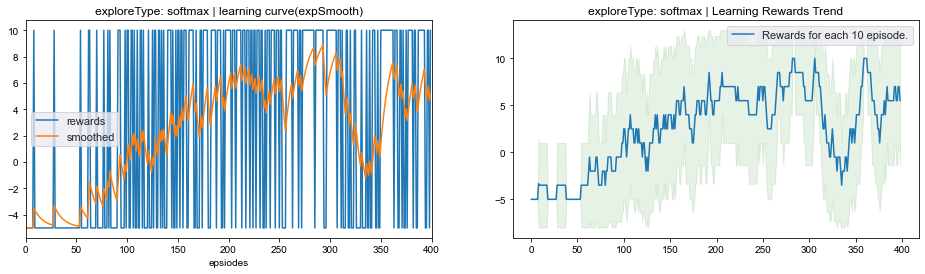

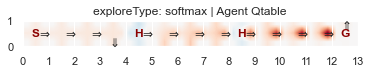

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = walkInThePark
状态数：48, 动作数：4


Config(Env=walkInThePark, Algo=Q-Learning, exploreType=softmax(gamma=0.9,learning_rate=0.1))

环境:walkInThePark, 算法:Q-Learning, 设备:cpu


Tarin[ 18/400 ](Epsilon：0.650):   7%|██▏                              | 27/400 [00:00<00:03, 95.93it/s, reward=-2.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.650): 100%|██████████████████████████████| 400/400 [00:02<00:00, 173.48it/s, reward=10.000]


环境：walkInThePark, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.650): 100%|███████████████████████████████████| 20/20 [00:00<00:00, 339.88it/s, reward=10.000]]


convEps: 114


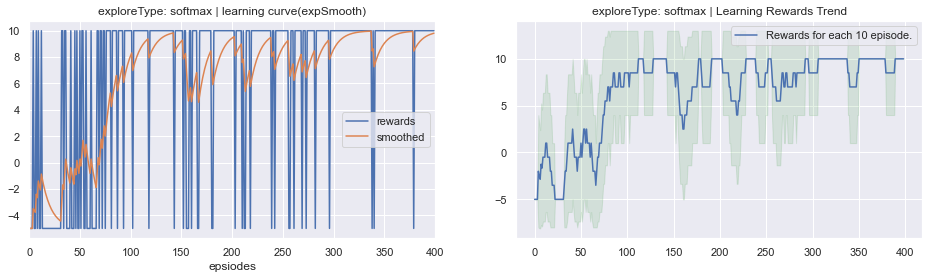

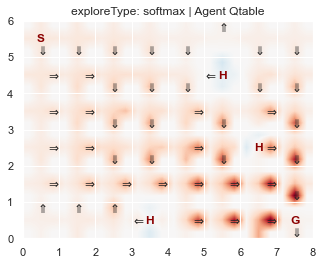

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = FrozenLakeEasy-v0
状态数：16, 动作数：4


Config(Env=FrozenLakeEasy-v0, Algo=Q-Learning, exploreType=softmax(gamma=0.9,learning_rate=0.1))

环境:FrozenLakeEasy-v0, 算法:Q-Learning, 设备:cpu


Tarin[ 62/400 ](Epsilon：0.650):  24%|████████                         | 97/400 [00:00<00:00, 355.56it/s, reward=0.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.650): 100%|███████████████████████████████| 400/400 [00:01<00:00, 367.36it/s, reward=0.100]


环境：FrozenLakeEasy-v0, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.650): 100%|████████████████████████████████████| 20/20 [00:00<00:00, 396.89it/s, reward=0.000]]


convEps: 400


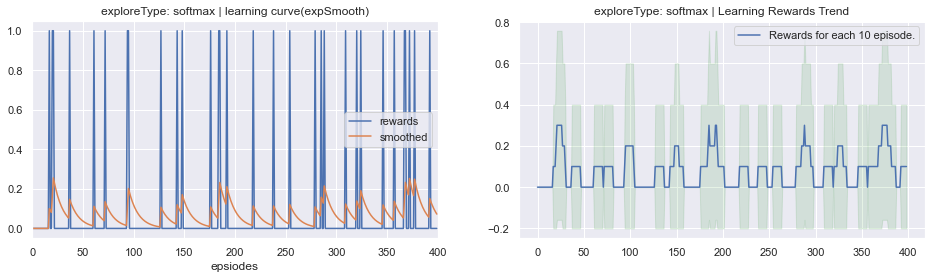

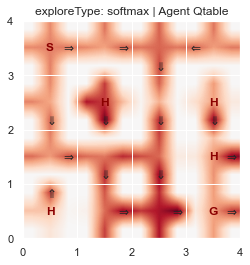

In [10]:
cfg.explore_type = 'softmax'

for env_name, env in env_dict.items():
    print('---'*45)
    print(f'EnvName = {env_name}')
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    print(f'状态数：{n_states}, 动作数：{n_actions}')
    setattr(cfg, 'env_name', env_name)
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions)
    cs.print(cfg)
    agent = QLearning(cfg)
    train_res = train(cfg, env, agent) # TODO：这里输出结果用字典表示，方便后面提取数据
    final_play_res = test(cfg, env, agent)
    # summary
    summary_dict['envName'].append(env_name)
    summary_dict['algoName'].append(train_res['algo'])
    summary_dict['exploreType'].append(train_res['explore_type'])
    summary_dict['convEps'].append(train_res['conv_eps'])
    summary_dict['meanReward'].append(final_play_res['meanReward'])
    summary_dict['meanSteps'].append(final_play_res['meanSteps'])
    print('convEps:', summary_dict['convEps'][-1])
    # Plot
    PLOTER = QTablePlot(agent.Q_table, env)
    PLOTER.rewards_plot(train_res['rewards'], title=f'exploreType: {cfg.explore_type} | ')
    PLOTER.Qtable_plot(f'exploreType: {cfg.explore_type} | ')

## 5.2、epsilon_greedy 策略探索

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = theAlley
状态数：13, 动作数：4


Config(Env=theAlley, Algo=Q-Learning, exploreType=epsilon_greedy(gamma=0.9,learning_rate=0.1))

环境:theAlley, 算法:Q-Learning, 设备:cpu


Tarin[ 12/400 ](Epsilon：0.005):   5%|█▋                               | 20/400 [00:00<00:05, 75.74it/s, reward=-2.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.005): 100%|████████████████████████████████| 400/400 [00:09<00:00, 42.65it/s, reward=0.000]


环境：theAlley, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.005): 100%|█████████████████████████████████████| 20/20 [00:00<00:00, 75.61it/s, reward=0.000]]


convEps: 400


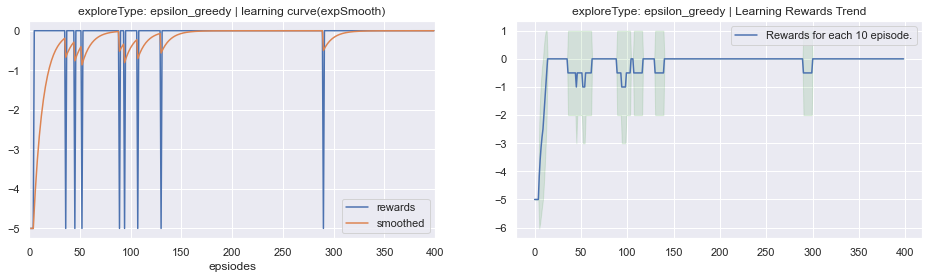

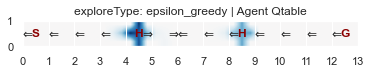

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = walkInThePark
状态数：48, 动作数：4


Config(Env=walkInThePark, Algo=Q-Learning, exploreType=epsilon_greedy(gamma=0.9,learning_rate=0.1))

环境:walkInThePark, 算法:Q-Learning, 设备:cpu


Tarin[ 21/400 ](Epsilon：0.005):   9%|██▉                              | 35/400 [00:00<00:02, 126.91it/s, reward=1.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.005): 100%|██████████████████████████████| 400/400 [00:02<00:00, 176.94it/s, reward=10.000]


环境：walkInThePark, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.005): 100%|███████████████████████████████████| 20/20 [00:00<00:00, 331.33it/s, reward=10.000]]


convEps: 94


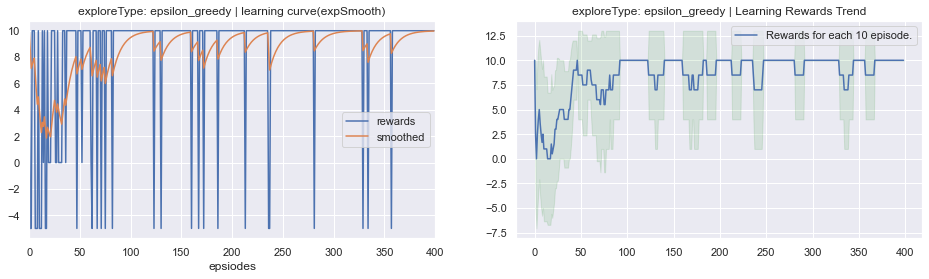

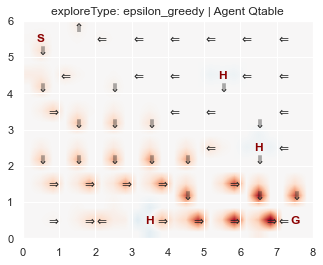

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = FrozenLakeEasy-v0
状态数：16, 动作数：4


Config(Env=FrozenLakeEasy-v0, Algo=Q-Learning, exploreType=epsilon_greedy(gamma=0.9,learning_rate=0.1))

环境:FrozenLakeEasy-v0, 算法:Q-Learning, 设备:cpu


Tarin[ 73/400 ](Epsilon：0.008):  28%|█████████                       | 114/400 [00:00<00:00, 418.93it/s, reward=0.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.005): 100%|███████████████████████████████| 400/400 [00:01<00:00, 369.39it/s, reward=1.000]


环境：FrozenLakeEasy-v0, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.005): 100%|████████████████████████████████████| 20/20 [00:00<00:00, 323.42it/s, reward=1.000]]


convEps: 156


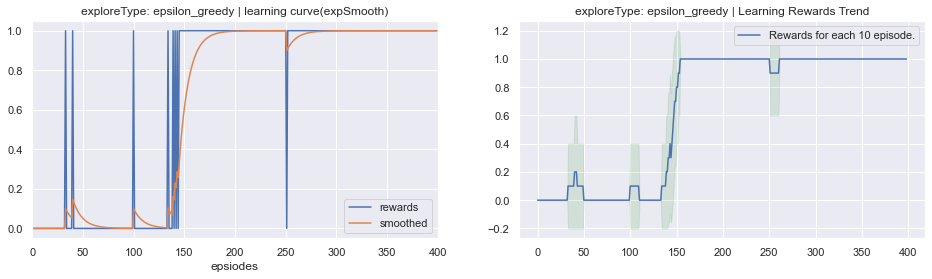

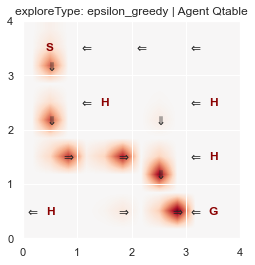

In [11]:
cfg.explore_type = 'epsilon_greedy'

for env_name, env in env_dict.items():
    print('---'*45)
    print(f'EnvName = {env_name}')
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    print(f'状态数：{n_states}, 动作数：{n_actions}')
    setattr(cfg, 'env_name', env_name)
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions)
    cs.print(cfg)
    agent = QLearning(cfg)
    train_res = train(cfg, env, agent) # TODO：这里输出结果用字典表示，方便后面提取数据
    final_play_res = test(cfg, env, agent)
    # summary
    summary_dict['envName'].append(env_name)
    summary_dict['algoName'].append(train_res['algo'])
    summary_dict['exploreType'].append(train_res['explore_type'])
    summary_dict['convEps'].append(train_res['conv_eps'])
    summary_dict['meanReward'].append(final_play_res['meanReward'])
    summary_dict['meanSteps'].append(final_play_res['meanSteps'])
    print('convEps:', summary_dict['convEps'][-1])
    # Plot
    PLOTER = QTablePlot(agent.Q_table, env)
    PLOTER.rewards_plot(train_res['rewards'], title=f'exploreType: {cfg.explore_type} | ')
    PLOTER.Qtable_plot(f'exploreType: {cfg.explore_type} | ')

## 5.3、boltzmann 策略探索

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = theAlley
状态数：13, 动作数：4


Config(Env=theAlley, Algo=Q-Learning, exploreType=boltzmann(gamma=0.9,learning_rate=0.1))

环境:theAlley, 算法:Q-Learning, 设备:cpu


Tarin[ 18/400 ](Epsilon：0.650):   7%|██▍                              | 29/400 [00:00<00:03, 98.22it/s, reward=-5.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.650): 100%|████████████████████████████████| 400/400 [00:04<00:00, 99.99it/s, reward=2.500]


环境：theAlley, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.650): 100%|███████████████████████████████████| 20/20 [00:00<00:00, 161.05it/s, reward=-0.500]]


convEps: 400


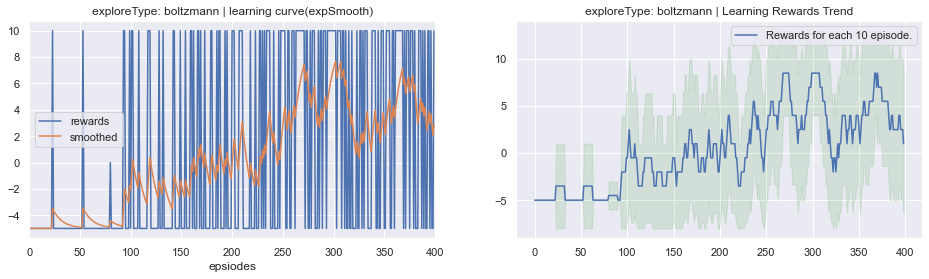

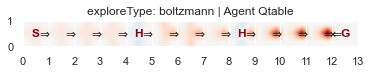

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = walkInThePark
状态数：48, 动作数：4


Config(Env=walkInThePark, Algo=Q-Learning, exploreType=boltzmann(gamma=0.9,learning_rate=0.1))

环境:walkInThePark, 算法:Q-Learning, 设备:cpu


Tarin[ 18/400 ](Epsilon：0.650):   7%|██▏                              | 27/400 [00:00<00:03, 96.82it/s, reward=-3.500]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.650): 100%|██████████████████████████████| 400/400 [00:02<00:00, 160.69it/s, reward=10.000]


环境：walkInThePark, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.650): 100%|███████████████████████████████████| 20/20 [00:00<00:00, 258.69it/s, reward=10.000]]


convEps: 143


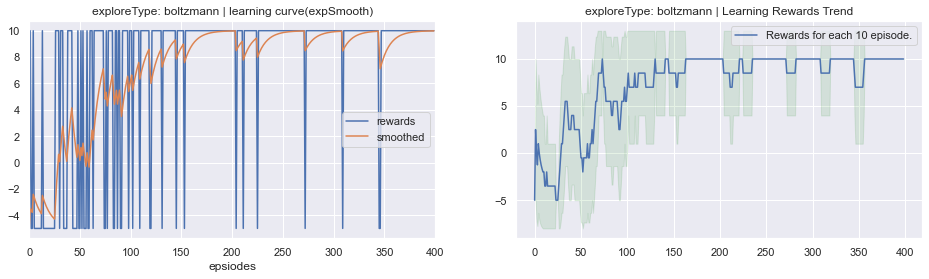

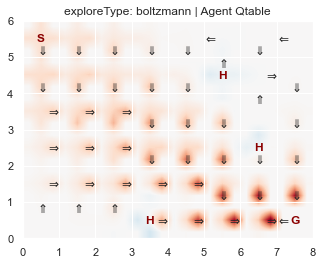

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = FrozenLakeEasy-v0
状态数：16, 动作数：4


Config(Env=FrozenLakeEasy-v0, Algo=Q-Learning, exploreType=boltzmann(gamma=0.9,learning_rate=0.1))

环境:FrozenLakeEasy-v0, 算法:Q-Learning, 设备:cpu


Tarin[ 61/400 ](Epsilon：0.650):  24%|████████                         | 97/400 [00:00<00:00, 365.34it/s, reward=0.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.650): 100%|███████████████████████████████| 400/400 [00:01<00:00, 324.44it/s, reward=0.000]


环境：FrozenLakeEasy-v0, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.650): 100%|████████████████████████████████████| 20/20 [00:00<00:00, 331.33it/s, reward=0.000]]


convEps: 400


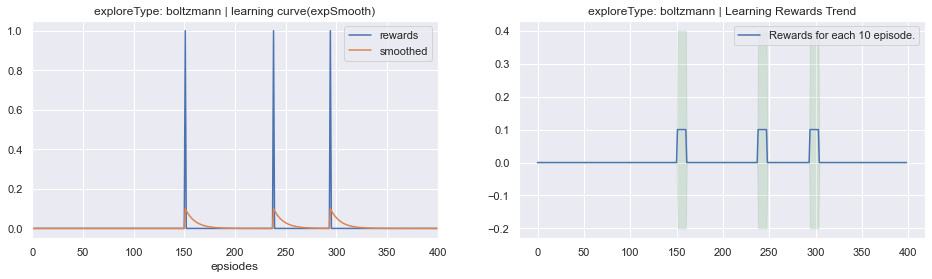

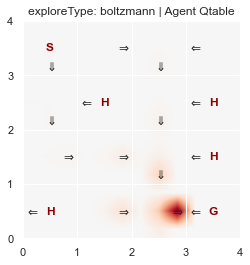

In [12]:
cfg.explore_type = 'boltzmann'

for env_name, env in env_dict.items():
    print('---'*45)
    print(f'EnvName = {env_name}')
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    print(f'状态数：{n_states}, 动作数：{n_actions}')
    setattr(cfg, 'env_name', env_name)
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions)
    cs.print(cfg)
    agent = QLearning(cfg)
    train_res = train(cfg, env, agent) # TODO：这里输出结果用字典表示，方便后面提取数据
    final_play_res = test(cfg, env, agent)
    # summary
    summary_dict['envName'].append(env_name)
    summary_dict['algoName'].append(train_res['algo'])
    summary_dict['exploreType'].append(train_res['explore_type'])
    summary_dict['convEps'].append(train_res['conv_eps'])
    summary_dict['meanReward'].append(final_play_res['meanReward'])
    summary_dict['meanSteps'].append(final_play_res['meanSteps'])
    print('convEps:', summary_dict['convEps'][-1])
    # Plot
    PLOTER = QTablePlot(agent.Q_table, env)
    PLOTER.rewards_plot(train_res['rewards'], title=f'exploreType: {cfg.explore_type} | ')
    PLOTER.Qtable_plot(f'exploreType: {cfg.explore_type} | ')

## 5.4、thompson 策略探索

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = theAlley
状态数：13, 动作数：4


Config(Env=theAlley, Algo=Q-Learning, exploreType=thompson(gamma=0.9,learning_rate=0.1))

环境:theAlley, 算法:Q-Learning, 设备:cpu


Tarin[ 24/400 ](Epsilon：0.650):   9%|██▉                             | 36/400 [00:00<00:02, 125.91it/s, reward=-5.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.650): 100%|███████████████████████████████| 400/400 [00:03<00:00, 107.30it/s, reward=5.500]


环境：theAlley, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.650): 100%|████████████████████████████████████| 20/20 [00:00<00:00, 147.97it/s, reward=8.500]]


convEps: 400


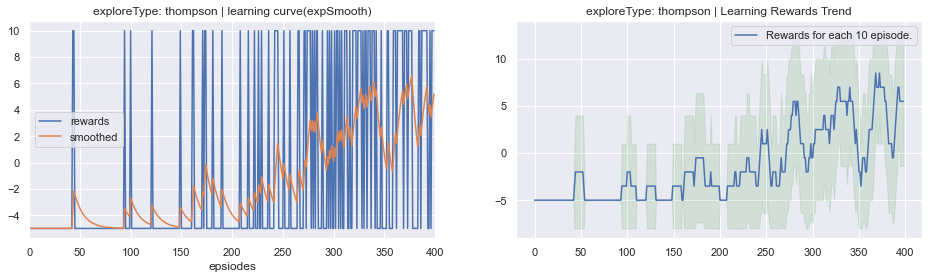

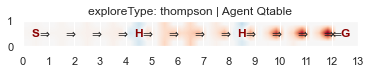

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = walkInThePark
状态数：48, 动作数：4


Config(Env=walkInThePark, Algo=Q-Learning, exploreType=thompson(gamma=0.9,learning_rate=0.1))

环境:walkInThePark, 算法:Q-Learning, 设备:cpu


Tarin[ 17/400 ](Epsilon：0.650):   6%|██▏                               | 26/400 [00:00<00:03, 97.80it/s, reward=1.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.650): 100%|██████████████████████████████| 400/400 [00:02<00:00, 143.44it/s, reward=10.000]


环境：walkInThePark, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.650): 100%|███████████████████████████████████| 20/20 [00:00<00:00, 244.55it/s, reward=10.000]]


convEps: 74


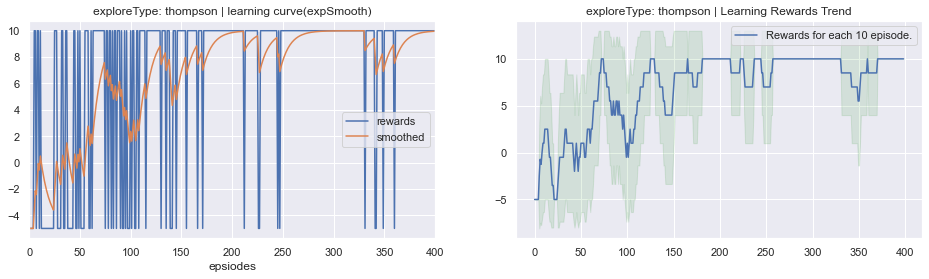

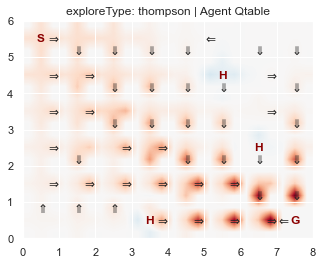

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = FrozenLakeEasy-v0
状态数：16, 动作数：4


Config(Env=FrozenLakeEasy-v0, Algo=Q-Learning, exploreType=thompson(gamma=0.9,learning_rate=0.1))

环境:FrozenLakeEasy-v0, 算法:Q-Learning, 设备:cpu


Tarin[ 67/400 ](Epsilon：0.650):  26%|████████▎                       | 104/400 [00:00<00:00, 375.29it/s, reward=0.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.650): 100%|███████████████████████████████| 400/400 [00:01<00:00, 323.49it/s, reward=0.100]


环境：FrozenLakeEasy-v0, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.650): 100%|████████████████████████████████████| 20/20 [00:00<00:00, 233.17it/s, reward=0.000]]


convEps: 400


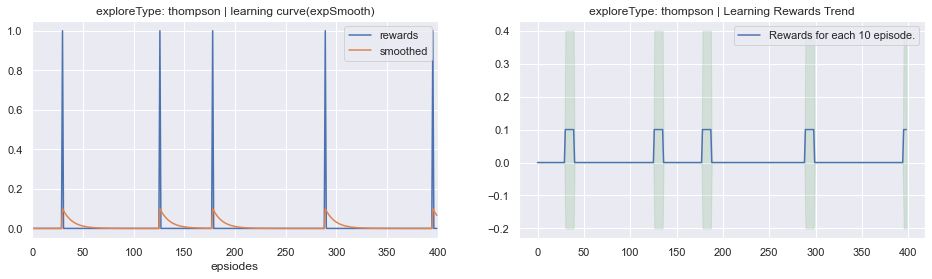

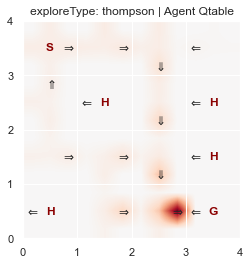

In [13]:
cfg.explore_type = 'thompson'


for env_name, env in env_dict.items():
    print('---'*45)
    print(f'EnvName = {env_name}')
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    print(f'状态数：{n_states}, 动作数：{n_actions}')
    setattr(cfg, 'env_name', env_name)
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions)
    cs.print(cfg)
    agent = QLearning(cfg)
    train_res = train(cfg, env, agent) # TODO：这里输出结果用字典表示，方便后面提取数据
    final_play_res = test(cfg, env, agent)
    # summary
    summary_dict['envName'].append(env_name)
    summary_dict['algoName'].append(train_res['algo'])
    summary_dict['exploreType'].append(train_res['explore_type'])
    summary_dict['convEps'].append(train_res['conv_eps'])
    summary_dict['meanReward'].append(final_play_res['meanReward'])
    summary_dict['meanSteps'].append(final_play_res['meanSteps'])
    print('convEps:', summary_dict['convEps'][-1])
    # Plot
    PLOTER = QTablePlot(agent.Q_table, env)
    PLOTER.rewards_plot(train_res['rewards'], title=f'exploreType: {cfg.explore_type} | ')
    PLOTER.Qtable_plot(f'exploreType: {cfg.explore_type} | ')

## 5.5、ucb 策略探索

special_ucb 在前期用e-greedy进行了初始化

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = theAlley
状态数：13, 动作数：4


Config(Env=theAlley, Algo=Q-Learning, exploreType=ucb(gamma=0.9,learning_rate=0.1))

环境:theAlley, 算法:Q-Learning, 设备:cpu


Tarin[ 5/400 ](Epsilon：0.650):   2%|▋                                   | 7/400 [00:00<00:14, 26.27it/s, reward=0.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.650): 100%|████████████████████████████████| 400/400 [00:14<00:00, 26.89it/s, reward=0.000]


环境：theAlley, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.650): 100%|█████████████████████████████████████| 20/20 [00:00<00:00, 73.83it/s, reward=0.000]]


convEps: 400


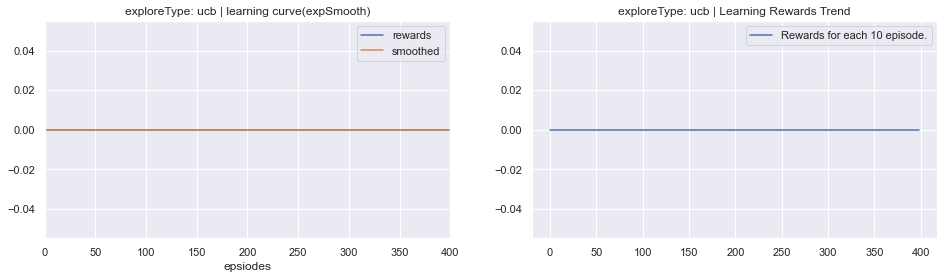

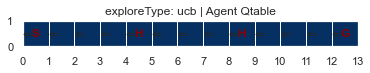

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = walkInThePark
状态数：48, 动作数：4


Config(Env=walkInThePark, Algo=Q-Learning, exploreType=ucb(gamma=0.9,learning_rate=0.1))

环境:walkInThePark, 算法:Q-Learning, 设备:cpu


Tarin[ 6/400 ](Epsilon：0.650):   2%|▋                                   | 8/400 [00:00<00:13, 28.10it/s, reward=0.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.650): 100%|████████████████████████████████| 400/400 [00:14<00:00, 27.32it/s, reward=0.000]


环境：walkInThePark, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.650): 100%|█████████████████████████████████████| 20/20 [00:00<00:00, 77.89it/s, reward=0.000]]


convEps: 400


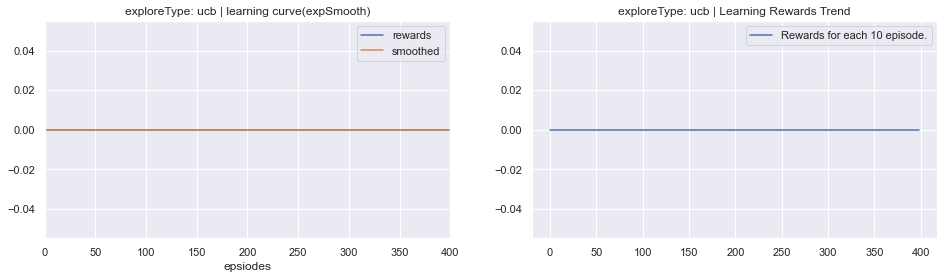

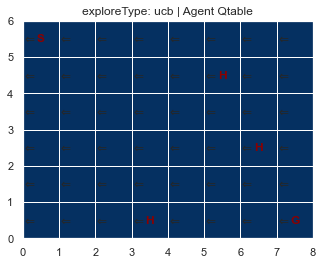

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = FrozenLakeEasy-v0
状态数：16, 动作数：4


Config(Env=FrozenLakeEasy-v0, Algo=Q-Learning, exploreType=ucb(gamma=0.9,learning_rate=0.1))

环境:FrozenLakeEasy-v0, 算法:Q-Learning, 设备:cpu


Tarin[ 7/400 ](Epsilon：0.650):   2%|▉                                  | 10/400 [00:00<00:10, 36.96it/s, reward=0.000]]

Set env random_seed = 1


Tarin[ 400/400 ](Epsilon：0.650): 100%|████████████████████████████████| 400/400 [00:14<00:00, 27.52it/s, reward=0.000]


环境：FrozenLakeEasy-v0, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.650): 100%|█████████████████████████████████████| 20/20 [00:00<00:00, 87.73it/s, reward=0.000]]


convEps: 400


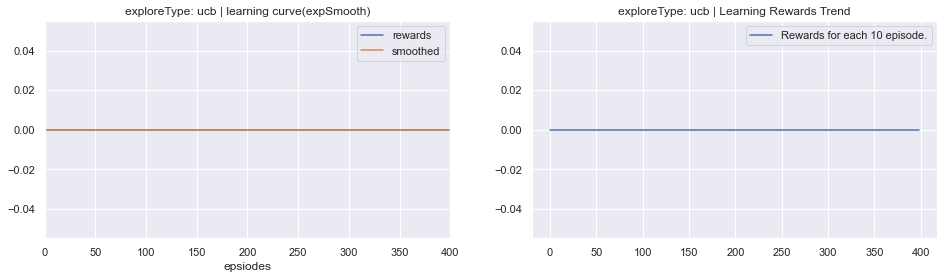

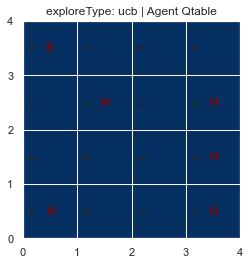

In [14]:
cfg.explore_type = 'ucb'

for env_name, env in env_dict.items():
    print('---'*45)
    print(f'EnvName = {env_name}')
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    print(f'状态数：{n_states}, 动作数：{n_actions}')
    setattr(cfg, 'env_name', env_name)
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions)
    cs.print(cfg)
    agent = QLearning(cfg)
    train_res = train(cfg, env, agent) # TODO：这里输出结果用字典表示，方便后面提取数据
    final_play_res = test(cfg, env, agent)
    # summary
    summary_dict['envName'].append(env_name)
    summary_dict['algoName'].append(train_res['algo'])
    summary_dict['exploreType'].append(train_res['explore_type'])
    summary_dict['convEps'].append(train_res['conv_eps'])
    summary_dict['meanReward'].append(final_play_res['meanReward'])
    summary_dict['meanSteps'].append(final_play_res['meanSteps'])
    print('convEps:', summary_dict['convEps'][-1])
    # Plot
    PLOTER = QTablePlot(agent.Q_table, env)
    PLOTER.rewards_plot(train_res['rewards'], title=f'exploreType: {cfg.explore_type} | ')
    PLOTER.Qtable_plot(f'exploreType: {cfg.explore_type} | ')

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = theAlley
状态数：13, 动作数：4


Config(Env=theAlley, Algo=Q-Learning, exploreType=special_ucb(gamma=0.9,learning_rate=0.1))

环境:theAlley, 算法:Q-Learning, 设备:cpu


Tarin[ 20/400 ](Epsilon：0.349):   8%|██▌                             | 32/400 [00:00<00:02, 129.63it/s, reward=-3.500]]

Set env random_seed = 1
UCB-Start 64


Tarin[ 400/400 ](Epsilon：0.349): 100%|████████████████████████████████| 400/400 [00:15<00:00, 25.49it/s, reward=0.000]


环境：theAlley, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.349): 100%|█████████████████████████████████████| 20/20 [00:00<00:00, 73.42it/s, reward=0.000]]


convEps: 400


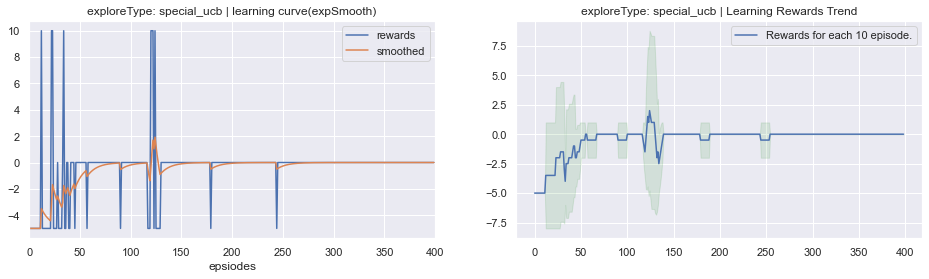

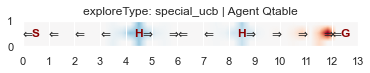

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = walkInThePark
状态数：48, 动作数：4


Config(Env=walkInThePark, Algo=Q-Learning, exploreType=special_ucb(gamma=0.9,learning_rate=0.1))

环境:walkInThePark, 算法:Q-Learning, 设备:cpu


Tarin[ 14/400 ](Epsilon：0.310):   5%|█▋                               | 20/400 [00:00<00:05, 65.22it/s, reward=-2.000]]

Set env random_seed = 1
UCB-Start 76


Tarin[ 400/400 ](Epsilon：0.310): 100%|██████████████████████████████| 400/400 [00:02<00:00, 176.69it/s, reward=10.000]


环境：walkInThePark, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.310): 100%|███████████████████████████████████| 20/20 [00:00<00:00, 313.29it/s, reward=10.000]]


convEps: 67


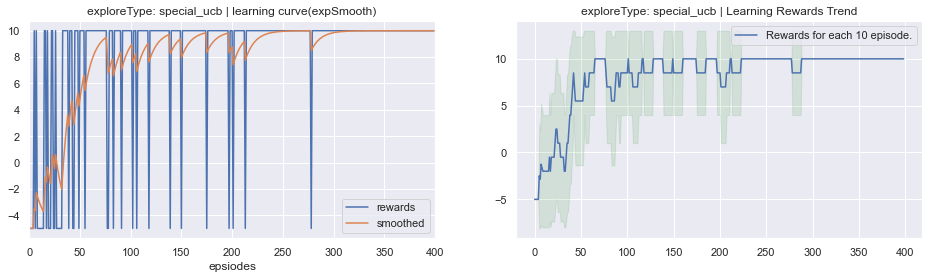

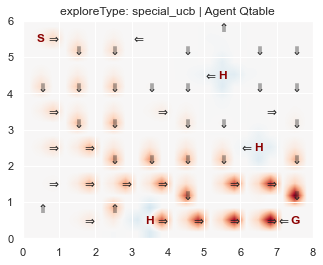

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = FrozenLakeEasy-v0
状态数：16, 动作数：4


Config(Env=FrozenLakeEasy-v0, Algo=Q-Learning, exploreType=special_ucb(gamma=0.9,learning_rate=0.1))

环境:FrozenLakeEasy-v0, 算法:Q-Learning, 设备:cpu


Tarin[ 61/400 ](Epsilon：0.451):  23%|███████▌                         | 92/400 [00:00<00:00, 312.95it/s, reward=0.000]]

Set env random_seed = 1
UCB-Start 38


Tarin[ 400/400 ](Epsilon：0.451): 100%|███████████████████████████████| 400/400 [00:01<00:00, 286.00it/s, reward=1.000]


环境：FrozenLakeEasy-v0, 算法：Q-Learning, 设备：cpu


Test[ 20/20 ](Epsilon：0.451): 100%|████████████████████████████████████| 20/20 [00:00<00:00, 354.80it/s, reward=1.000]]


convEps: 320


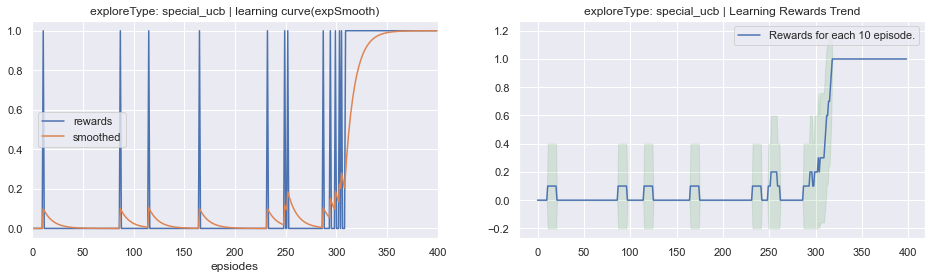

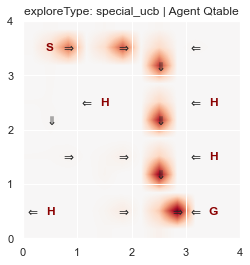

In [15]:
cfg.explore_type = 'special_ucb'

for env_name, env in env_dict.items():
    print('---'*45)
    print(f'EnvName = {env_name}')
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    print(f'状态数：{n_states}, 动作数：{n_actions}')
    setattr(cfg, 'env_name', env_name)
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions)
    cs.print(cfg)
    agent = QLearning(cfg)
    train_res = train(cfg, env, agent) # TODO：这里输出结果用字典表示，方便后面提取数据
    final_play_res = test(cfg, env, agent)
    # summary
    summary_dict['envName'].append(env_name)
    summary_dict['algoName'].append(train_res['algo'])
    summary_dict['exploreType'].append(train_res['explore_type'])
    summary_dict['convEps'].append(train_res['conv_eps'])
    summary_dict['meanReward'].append(final_play_res['meanReward'])
    summary_dict['meanSteps'].append(final_play_res['meanSteps'])
    print('convEps:', summary_dict['convEps'][-1])
    # Plot
    PLOTER = QTablePlot(agent.Q_table, env)
    PLOTER.rewards_plot(train_res['rewards'], title=f'exploreType: {cfg.explore_type} | ')
    PLOTER.Qtable_plot(f'exploreType: {cfg.explore_type} | ')

## &#x2728; 6、总结
<font color=darkred>

- &#x1F4CD; 在action有限的情况下，一般epsilon_greedy探索策略更加的简单高效, 可以将epsilon_greedy探索策略作为第一选择策略    
- &#x1F4CD; 在epsilon_greedy探索策略表现不佳的时候，我们可以第一优先使用softmax探索策略  
</font>

**1- `softmax`探索策略：**
- 在`FrozenLakeEasy-v0` 环境中难以收敛
    - 训练好的QTable几乎不可用：
      - 在`FrozenLakeEasy-v0`: 进行20轮游戏，每局平均获取奖励0.10，每局行动8.35步
- 在`theAlley` <font color=darkred>进行284轮次之后收敛</font>，用训练好的QTable进行20轮游戏，每局平均获取奖励4.75，每局行动42.10步。
- 在`walkInThePark` <font color=darkred>进行114轮次之后收敛</font>，用训练好的QTable进行20轮游戏，每局平均获取奖励10，每局行动17.95步。

**2- `epsilon_greedy`探索策略：**
- 在`theAlley` 环境中难以收敛且训练的QTable不可用
- 在`FrozenLakeEasy-v0` <font color=darkred>进行156轮次之后收敛</font>，用训练好的QTable进行20轮游戏，每局平均获取奖励1，每局行动6步。
- 在`walkInThePark` <font color=darkred>进行94轮次之后收敛</font>，用训练好的QTable进行20轮游戏，每局平均获取奖励10，每局行动15步。


**3- `boltzmann`探索策略：**
- `theAlley` 和 `FrozenLakeEasy-v0` 环境中难以收敛
    - 训练好的QTable有一定的可用性：
      - 在`theAlley` ：进行20轮游戏，每局平均获取奖励3.25，每局行动39.05步
      - 在`FrozenLakeEasy-v0` 中几乎不可用
- 在`walkInThePark` <font color=darkred>进行143轮次之后收敛</font>，用训练好的QTable进行20轮游戏，每局平均获取奖励10，每局行动15.25步。



**4- `thompson`探索策略：**
- `theAlley` 和 `FrozenLakeEasy-v0` 环境中难以收敛
    - 训练好的QTable有一定的可用性：
      - 在`theAlley` ：进行20轮游戏，每局平均获取奖励6.25，每局行动43.55步
      - 在`FrozenLakeEasy-v0` 中几乎不可用
- 在`walkInThePark` <font color=darkred>进行74轮次之后收敛</font>，用训练好的QTable进行20轮游戏，每局平均获取奖励10，每局行动16.05步。

**5-`ucb`探索策略：**
- 在`theAlley`、 `FrozenLakeEasy-v0` 和 `walkInThePark` 环境中均难以收敛
- 且训练的QTable不可用


**5- `special_ucb`探索策略：**
- 在`theAlley` 环境中难以收敛且训练的QTable不可用
- 在`FrozenLakeEasy-v0` <font color=darkred>进行320轮次之后收敛</font>，用训练好的QTable进行20轮游戏，每局平均获取奖励1，每局行动6步。
- 在`walkInThePark` <font color=darkred>进行67轮次之后收敛</font>，用训练好的QTable进行20轮游戏，每局平均获取奖励10，每局行动15步。


In [16]:
import pandas as pd
display(pd.DataFrame(summary_dict).sort_values(by='exploreType'))
pd.DataFrame(summary_dict).sort_values(by=['envName', 'meanReward'])

,envName,algoName,exploreType,convEps,meanReward,meanSteps
8,FrozenLakeEasy-v0,Q-Learning,boltzmann,400,0.00,6.20
7,walkInThePark,Q-Learning,boltzmann,143,10.00,15.25
6,theAlley,Q-Learning,boltzmann,400,3.25,39.05
3,theAlley,Q-Learning,epsilon_greedy,400,0.00,500.00
4,walkInThePark,Q-Learning,epsilon_greedy,94,10.00,15.00
5,FrozenLakeEasy-v0,Q-Learning,epsilon_greedy,156,1.00,6.00
0,theAlley,Q-Learning,softmax,284,4.75,42.10
1,walkInThePark,Q-Learning,softmax,114,10.00,17.95
2,FrozenLakeEasy-v0,Q-Learning,softmax,400,0.10,8.35
16,walkInThePark,Q-Learning,special_ucb,67,10.00,15.00


,envName,algoName,exploreType,convEps,meanReward,meanSteps
8,FrozenLakeEasy-v0,Q-Learning,boltzmann,400,0.00,6.20
11,FrozenLakeEasy-v0,Q-Learning,thompson,400,0.00,8.40
14,FrozenLakeEasy-v0,Q-Learning,ucb,400,0.00,500.00
2,FrozenLakeEasy-v0,Q-Learning,softmax,400,0.10,8.35
5,FrozenLakeEasy-v0,Q-Learning,epsilon_greedy,156,1.00,6.00
17,FrozenLakeEasy-v0,Q-Learning,special_ucb,320,1.00,6.00
3,theAlley,Q-Learning,epsilon_greedy,400,0.00,500.00
12,theAlley,Q-Learning,ucb,400,0.00,500.00
15,theAlley,Q-Learning,special_ucb,400,0.00,500.00
6,theAlley,Q-Learning,boltzmann,400,3.25,39.05
